In [120]:
import os
import torch
from torch.utils.data import DataLoader
from loguru import logger
import matplotlib.pyplot as plt
from dataset_processor.dataset_loader import VideoTensorDataset
from hyvideo.vae.autoencoder_kl_causal_3d import AutoencoderKLCausal3D
from hyvideo.vae import load_vae
from hyvideo.utils.file_utils import save_videos_grid
import datetime

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"

logger.info("Loading VAE...")
vae, _, s_ratio, t_ratio = load_vae(
    vae_type="884-16c-hy",           # 这里和你们项目里保持一致
    vae_precision="fp16",
    logger=logger,
    vae_path="ckpts/hunyuan-video-t2v-720p/vae",
    device=device,
)
logger.info("VAE loaded.")

# vae.enable_tiling()

# 加载数据集
dataset = VideoTensorDataset("/home/siyuan/HunyuanVideo_efficiency/results/idea_0/vae/data/tensor")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)


2025-02-24 13:46:35.374 | INFO     | __main__:<module>:3 - Loading VAE...
2025-02-24 13:46:35.375 | INFO     | hyvideo.vae:load_vae:29 - Loading 3D VAE model (884-16c-hy) from: ckpts/hunyuan-video-t2v-720p/vae
2025-02-24 13:46:38.888 | INFO     | hyvideo.vae:load_vae:55 - VAE to dtype: torch.float16
2025-02-24 13:46:38.992 | INFO     | __main__:<module>:11 - VAE loaded.


In [129]:
def fft_latents(latent, t_group_size=33, low_freq_factor=1.0, high_freq_factor=1.0):
    """
    对给定的潜在张量 `latent` (即 z) 按组（t_group_size）进行高低频分离，
    并通过系数调整高频和低频部分的强度。
    
    - latent: 输入的潜在张量
    - t_group_size: 每组时间步数
    - low_freq_factor: 调整低频部分的系数
    - high_freq_factor: 调整高频部分的系数
    """
    print(latent.shape)
    batch_size, num_channels, num_timesteps, height, width = latent.shape
    device = latent.device  # 使用输入张量的设备
    dtype = latent.dtype  # 使用输入张量的数据类型

    # 计算 T 维度需要多少个 generator
    num_t_groups = (num_timesteps + t_group_size - 1) // t_group_size  # 向上取整
    latents = torch.zeros(latent.shape, device=device, dtype=dtype)

    # 设置图形的大小和子图的布局
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # 3行4列的子图布局
    axes = axes.flatten()  # 将二维数组的 axes 拉平为一维，方便索引

    # 按组处理
    for t_group in range(min(num_t_groups, 11)):  # 只取前 11 个组
        t_start = t_group * t_group_size
        t_end = min((t_group + 1) * t_group_size, num_timesteps)  # 确保不会超出 T 维度

        # 取当前组的 z
        group_latent = latent[:, :, t_start:t_end, :, :]

        # 1. **进行 3D FFT (T, H, W)**
        group_fft = torch.fft.fftn(group_latent, dim=(-3, -2, -1))  # 计算 T, H, W 维度的频域变换
        #group_fft = torch.fft.fftshift(group_fft, dim=(-3, -2, -1))  # 频谱平移，将低频移到中心
        magnitude = torch.abs(group_fft)
        
        # 可视化当前组的幅度图
        magnitude_sample = magnitude[0, 0, 0].cpu().numpy()  # 选择第一个 batch, 第一个通道，第 0 个时间步
        axes[t_group].imshow(magnitude_sample, interpolation='none', cmap='viridis')

        # 设置横纵坐标标签
        axes[t_group].set_title(f"Magnitude of FFT (Group {t_group})")
        axes[t_group].set_xlabel("Frequency (Spatial/Time Step)")  # 横坐标标签
        axes[t_group].set_ylabel("Frequency (Spatial/Time Step)")  # 纵坐标标签

        axes[t_group].axis('on')  # 显示坐标轴

        # 2. **分离低频和高频**
        # 修改：基于每个时间步的组大小来确定低频和高频分离的阈值
        a = 1
        b = 10
        cutoff_t = t_group_size // a  # 每个时间组的低频截断
        cutoff_h = height // b  # 空间维度的低频截断
        cutoff_w = width // b

        mask = torch.zeros_like(group_fft)
        #mask[:, :, :cutoff_t, :cutoff_h, :cutoff_w] = 1  # 低频区域（左上角）
        #mask[:, :, -cutoff_t:, :cutoff_h, :cutoff_w] = 1  # 低频区域（右下角）
        #mask[:, :, :cutoff_t, -cutoff_h:, :cutoff_w] = 1  # 低频区域（左下角）
        #mask[:, :, -cutoff_t:, -cutoff_h:, :cutoff_w] = 1  # 低频区域（右上角）

        mask[:, :, :cutoff_t, :, :] = 1  # 低频区域（时间轴的前部分）
        mask[:, :, -cutoff_t:, :, :] = 1  # 低频区域（时间轴的后部分）
        
        low_freq = group_fft * mask  # 低频部分
        high_freq = group_fft * (1 - mask)  # 高频部分

        # 3. **应用系数来调整高频和低频**
        low_freq = low_freq * low_freq_factor  # 增强/减少低频
        high_freq = high_freq * high_freq_factor  # 增强/减少高频

        # 4. **合并低频和高频部分**
        mixed_fft = low_freq + high_freq

        # 5. **逆傅里叶变换**（将频域信号转换回时域）
        new_group = torch.fft.ifftn(mixed_fft, dim=(-3, -2, -1)).real  # 变换回时域

        # 6. **归一化，确保高斯分布**

        # 将处理后的组存入 latents
        latents[:, :, t_start:t_end, :, :] = new_group

    plt.tight_layout()  # 自动调整子图间距
    plt.show()

    return latents


In [130]:
# 3. 定义 infer_vae 函数

def infer_vae(model: AutoencoderKLCausal3D,
              dataloader: DataLoader,
              device: str,
              output_dir: str,
              max_files: int = None,
              mp4: bool = True):
    """
    Perform inference using the VAE model on video tensors.
    """
    model.to(device)
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    for batch_idx, (video_tensor, file_name) in enumerate(dataloader):
        if max_files is not None and batch_idx >= max_files:
            break  # Stop processing after reaching the max number of files

        # 去掉 .pt 后缀
        file_name = file_name[0].replace(".pt", "")

        # Move to device
        video_tensor = video_tensor.to(device, dtype=torch.float16)
        logger.info(f"Processing {file_name}, video shape: {video_tensor.shape}")

        with torch.no_grad():
            posterior = model.encode(video_tensor, return_dict=False)[0]
            z = posterior.mode()
            reconstructed_video = model.decode(fft_latents(z.to(dtype=torch.float32), t_group_size=3, low_freq_factor=1.0, high_freq_factor=0.0).to(dtype=torch.float16), return_dict=False)[0]
            #reconstructed_video = model.decode(z, return_dict=False)[0]
            
        reconstructed_video = reconstructed_video.cpu().float()
        output_path = os.path.join(output_dir, f"{file_name}.pt")
        torch.save(reconstructed_video, output_path)
        logger.info(f"Saved reconstructed video to {output_path}, shape: {reconstructed_video.shape}")

        # Optionally save mp4
        if mp4:
            current_time = datetime.datetime.now().strftime("%m%d_%H%M%S")
            save_path = os.path.join(output_dir, f"{file_name}_{current_time}.mp4")
            save_videos_grid(reconstructed_video, save_path, fps=15, rescale=True)
            logger.info(f'Sample saved to: {save_path}')

2025-02-24 13:54:17.141 | INFO     | __main__:infer_vae:26 - Processing video_240p, video shape: torch.Size([1, 3, 129, 160, 284])


torch.Size([1, 16, 33, 20, 36])


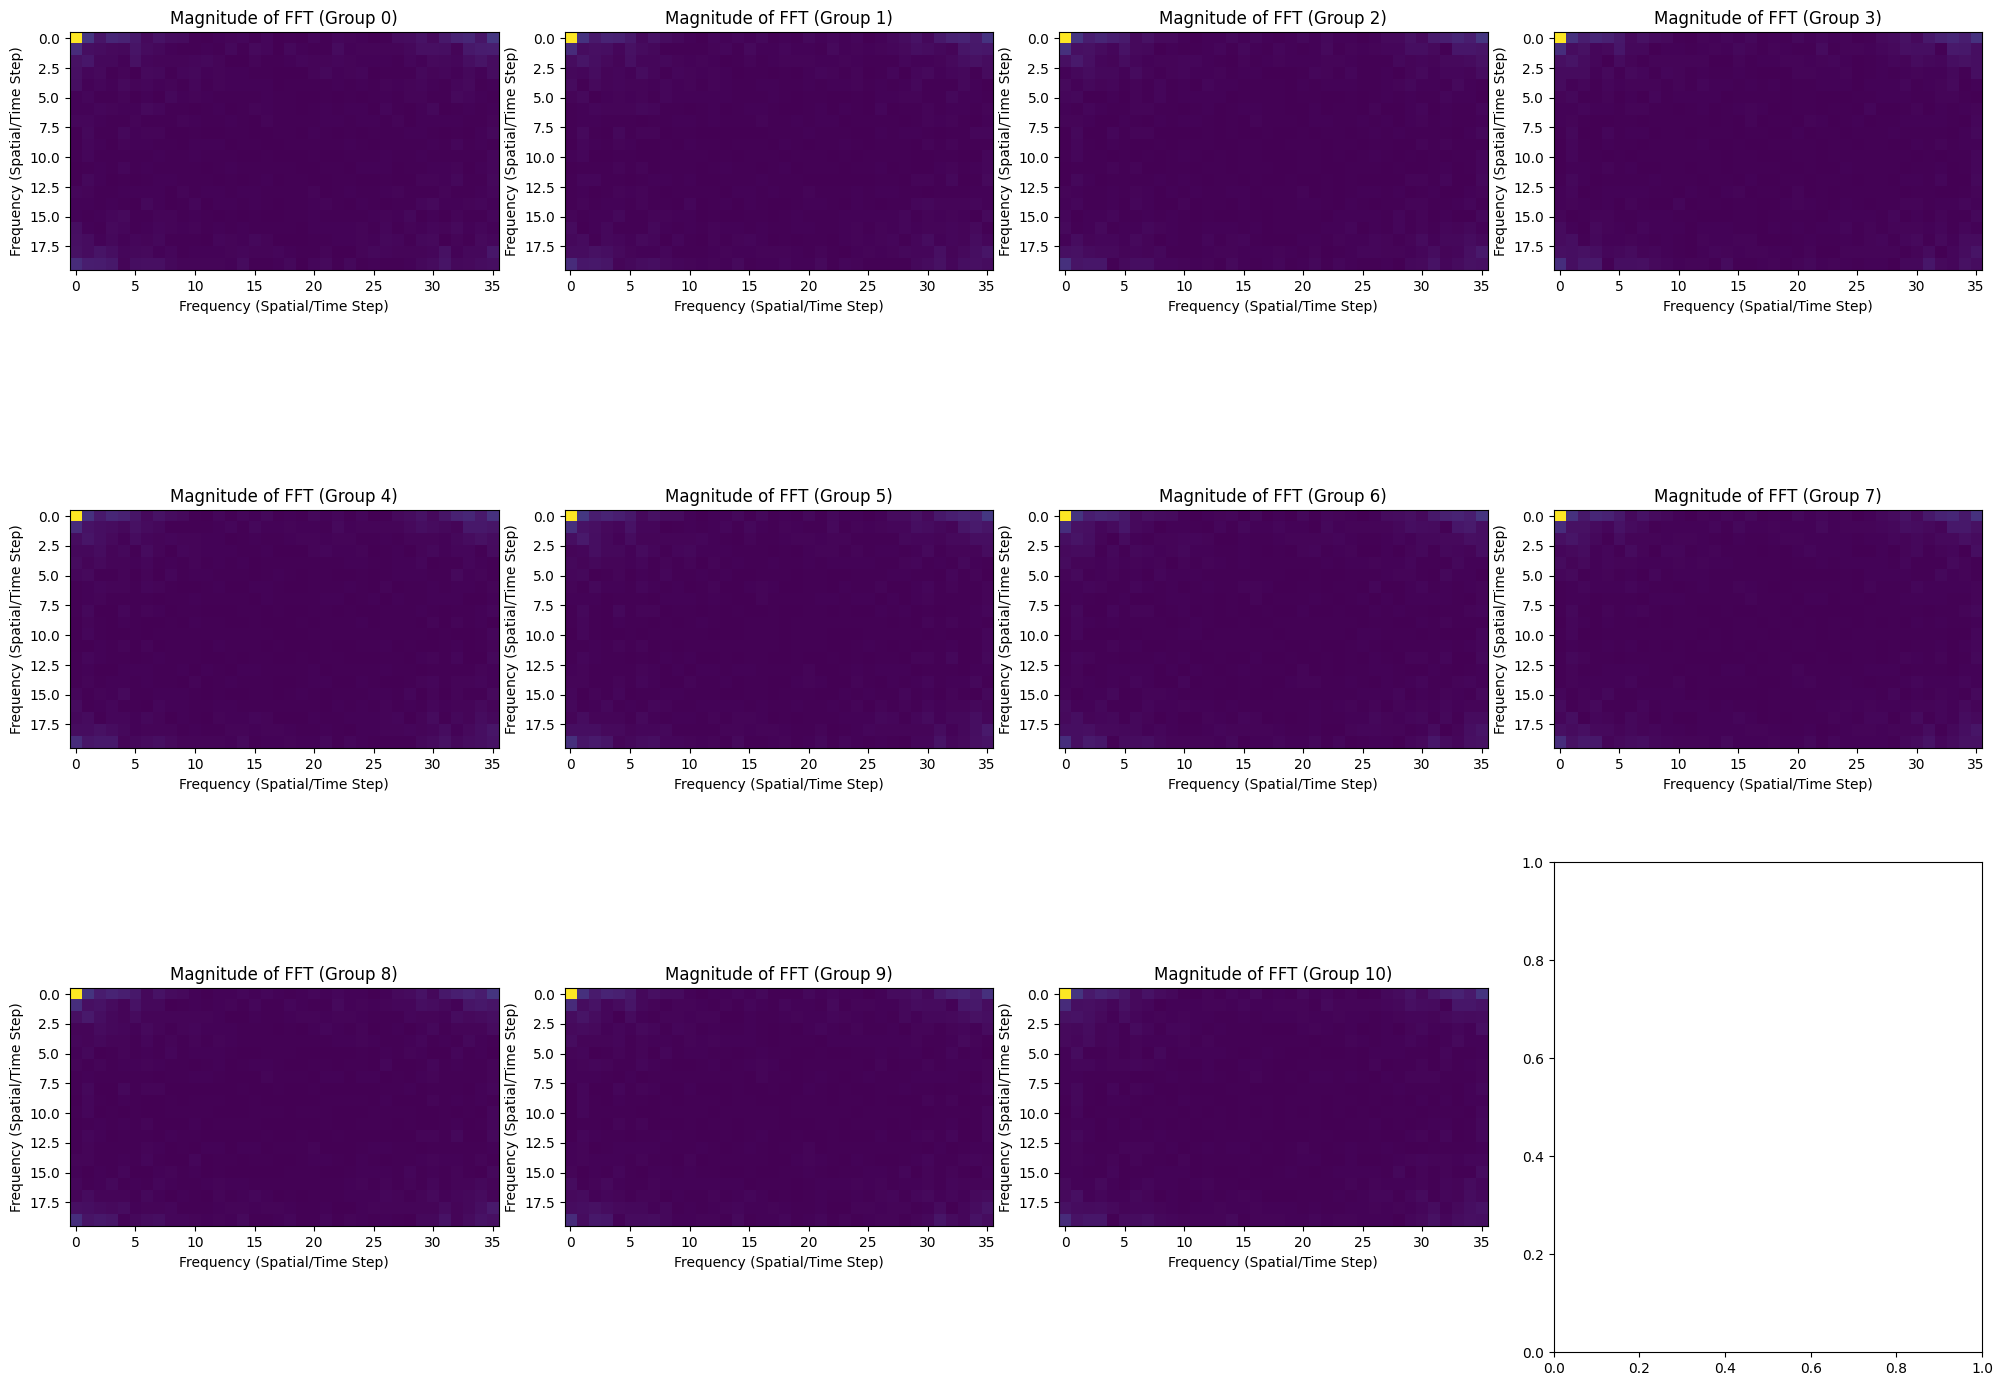

2025-02-24 13:54:20.821 | INFO     | __main__:infer_vae:37 - Saved reconstructed video to /home/siyuan/HunyuanVideo_efficiency/results/idea_0/vae/data/video_240p.pt, shape: torch.Size([1, 3, 129, 160, 288])
2025-02-24 13:54:21.163 | INFO     | __main__:infer_vae:44 - Sample saved to: /home/siyuan/HunyuanVideo_efficiency/results/idea_0/vae/data/video_240p_0224_135420.mp4


In [131]:
infer_vae(vae, dataloader, device, "/home/siyuan/HunyuanVideo_efficiency/results/idea_0/vae/data", max_files=1)